# **ST 563  | Data Splitting**

Here's a Jupter Notebook version referencing to pages 10-28 from *Chapter 2 - Model Building and Data Splitting* document.

**Disclaimer:** Although most text is repeated, this document has been rewritten in terms of the context of python along with additional concepts. So please be sure to read over this document thoroughly.

## **Packages & Initialization**

Here packages are installed and imported along with the Boston housing dataset with some basic initializations.

In [1]:
import numpy as np                                  # default, basic python package
import pandas as pd                                 # default, basic python package
import matplotlib.pyplot as plt                     # produces plots
from scipy.stats import gaussian_kde                # produces density curves

import random                                       # generates random numbers
from sklearn.utils import check_random_state        # generates random numbers (alternative method)

from sklearn.datasets import fetch_openml           # contains Boston dataset
from sklearn.neighbors import KNeighborsRegressor   # performs KNN Regression Modeling
#from sklearn.preprocessing import StandardScaler    # performs standardization/ normalizes data
from sklearn.pipeline import make_pipeline          # _
from sklearn.model_selection import (
    train_test_split,                               # performs holdout method (i.e., SRSWOR, similar to base R)
    ShuffleSplit,                                   # performs holdout method (similar to rsample)
    StratifiedShuffleSplit,                         # performs holdout method (similar to caret::createDataPartition)
    KFold,                                          # performs V-fold CV
    cross_val_score,                                # performs computed mse scores
    cross_validate,                                 # performs CV
    GridSearchCV,                                   # _
    LeaveOneOut                                     # performs LOOCV
)
from sklearn.ensemble import BaggingRegressor       # performs bootstrapping
from sklearn.metrics import make_scorer, mean_squared_error      # performs _ & computes mse scores

In [23]:
# Load Boston housing as a pandas DataFrame
  # Note: sklearn removed load_boston; fetch_openml keeps the dataset available
boston = fetch_openml(name="boston", version=1, as_frame=True)

boston_df = boston.frame
print(boston_df.shape)

(506, 14)


In [ ]:
#X = boston_df[["LSTAT"]].values
## Alternatively: X = boston.data[["LSTAT"]].values
#y = boston_df[["MEDV"]].values.astype(float)
## Alternatively: y = boston.target#.values.astype(float)
## -----------
## A simple KNN pipeline
#k= 30
#def knn_model(k):
##    return make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=k))
#    return make_pipeline(KNeighborsRegressor(n_neighbors=k))
## Alternatively: knn = KNeighborsRegressor(n_neighbors=k)

## **Introduction**

Let us re-examine KNN regression fit to Boston data. Suppose we use $K = 30$.

In [127]:
X = boston_df[["LSTAT"]].values
y = boston_df[["MEDV"]].values.astype(float)

# A simple KNN pipeline
k= 30
def knn_model(k):
    return make_pipeline(KNeighborsRegressor(n_neighbors=k))
knn = knn_model(k)
knn.fit(X, y)

y_pred = knn.predict(X)
mse_full= np.mean((y - y_pred)**2)
print("MSE (trains on full dataset):", round(mse_full,4))

MSE (trains on full dataset): 25.9078


Given that we trained on the entire dataset, we see that we have a training MSE about $25.91$. However, as we have discussed so far, relying on training MSE is not a good idea. Also, it is not a good idea to train on the entire dataset as well.

Instead, we want to know how the model performs on independent test data. Also, is $K = 30$ a good choice? Both both these issues, we need a test data set that we can use to evaluate our model's performance in general. We can the *holdout method* or resampling techniques such as *bootstrap* or *v-fold cross validation* to create test set from our data, and validate our models performance.

## **Holdout method**

Relates to pages 10-17.

### **Concept**

The holdout method randomly splits a given dataset into two sets: one for training and one for evaluation (the holdout/ validation/ test set).

In practice, $80\% -- 20\%, 70\% -- 30\% \text{ or } 60\% -- 40\%$ splits are commonly used for training/test sets. In general, we should keep in mind that putting too much data for training results in a small test set, which may not provide a good estimate of the model performance. On the other hand, putting too much data in the test set results in a small traing set, which results in poor model fitting. Other factors such as whether $p > n$ also may impact the split sizes.

A simple way to create such a split is via *Simple Random Sampling Without Replacement (SRSWOR)*, that is, by randomly choosing a subset of observations from the data set and putting them aside as the training set. The remaining observations form the holdout set.

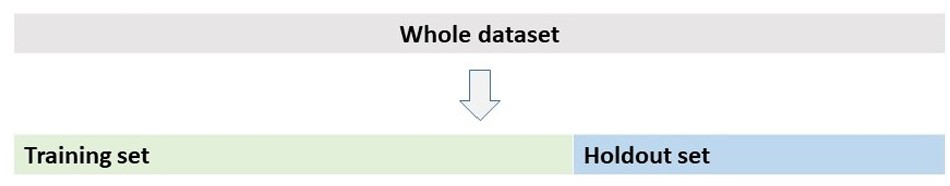

Figure 8 shows the basic layout of the holdout method.The whole dataset is split into two parts: traing and holdout sets.

advantages:
- conceptually and computationally simple.

disadvantages:

- can produce highly variable test error (e.g., substantial amount of variability in the test MSE).
- may overestimate the test error since we are fitting the statistical model with only a subset of the whole data.


Resolved if we repeat the inner/outer loops a few times, and take average of the resulting MSE values. Resampling techniques such as cross-validation provides a natural way to do so.

A disadvantage of SRSWOR is that it does not always preserve distribution of the response variable. For example, in a classification problem with two classes (‘Yes’ and ‘No’), we might have 70% individuals in ‘Yes’ group and the remaining 30% in the ‘No’ group. Performing SRSWOR in the data may lead to a test set with overrepresentation/under-representation of the groups. 15  In this case, a stratified sampling strategy is appropriate.

Stratified random sampling is used to explicitly control aspects of the distribution of Y. This is useful with data with small sample size or skewed response distribution. Stratified random sampling strategy is to draw sample for each group (strata) of Y so that the test set represents the distribution of Y of the whole data. We can use the initial_split() function as before for this purpose but with an extra argument strata.

If extreme class imbalance is present in the data (say 90% “No” and only 10% “Yes”), we might choose to over-sample the rare class, or under-sample the abundant class, or a combination of both the strategies can be employed. A popular technique in this regard is Synthetic Minority Over-sampling Technique (SMOTE), which generates synthetic samples from the rare class. In particular, SMOTE takes a random observation from the rare class and then finds its nearest neighbors in the rare class. Then SMOTE generate new samples using the convex combinations of the original randomly selected observation and one of the the nearest neighbors.

### **Application**

In [128]:
# Holdout (simple 80/20 split)

# A simple KNN pipeline
k= 30
def knn_model(k):
    return make_pipeline(KNeighborsRegressor(n_neighbors=k))
knn = knn_model(k)

# SRSWOR
rng = 100
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=rng, shuffle=True)
knn.fit(X_tr, y_tr)

pred_te = knn.predict(X_te)
MSE_test = mean_squared_error(y_te, pred_te)
print("Holdout Test MSE (K=30):", round(MSE_test, 4))

pred_tr = knn.predict(X_tr)
MSE_train = mean_squared_error(y_tr, pred_tr)
print("Holdout Train MSE (K=30):", round(MSE_train, 4))

Holdout Test MSE (K=30): 32.4376
Holdout Train MSE (K=30): 24.7124


**Trends:** It is as we expected that the training MSE most likely underestimates the prediction error, while test MSE can be viewed as a reasonable estimate of the same. (i.e., test MSE > train MSE)

**Reasoning:** On average, Train ≤ Test because we evaluate the model on data it has already “seen,” and KNN predictions on training points even include the point itself among neighbors, which tends to make train error optimistic (lower).

**Uncommonly:**
However even with proper computation, you can occasionally see Test < Train by chance (e.g., outliers concentrated in the train set, distribution shift between splits, small sample noise, etc.).


### **Figures**

7 plots

In [129]:
# Similar to using base R:

# set a seed for reproducible results
seed = random.seed(1234567)

# Samples 80% of row indices (without replacement)
n = boston_df.shape[0]
index = random.sample(range(n), k=round(0.8 * n))

# Training and test sets
train = boston_df.iloc[index, :]
test = boston_df.drop(index, axis=0)

# Data dimensions
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (405, 14)
Test shape: (101, 14)


In [130]:
# Similar to using caret in R:

# set a seed for reproducible results
seed = random.seed(1234567)

y = boston_df["MEDV"].values.astype(float)

# Create quantile bins of the response like caret does internally for regression
y_bins = pd.qcut(y, q=10, duplicates="drop")  # q=10 bins

train_2, test_2 = train_test_split(
    boston_df,
    test_size=0.2,          # 1 - prop
    random_state=seed,
    stratify=y_bins         # stratified on binned y
)

print(train_2.shape, test_2.shape)

(404, 14) (102, 14)


In [131]:
# Similar to using rsample in R:

# set a seed for reproducible results
seed = random.seed(1234567)

train_3, test_3 = train_test_split(
    boston_df,
    test_size=0.2,
    random_state=seed,
    shuffle=True            # simple SRSWOR (holdout), without stratification
)
print(train_3.shape, test_3.shape)

(404, 14) (102, 14)


We have split the data $80\% - 20\%$ in the example above. The following code chunk shows examples of SRSWOR using `train_test_split()` with straified splits with `pd.qcut()` (similar to `caret` in R) and without straified splits (similar to `rsample` in R), if we want to split the data manually.

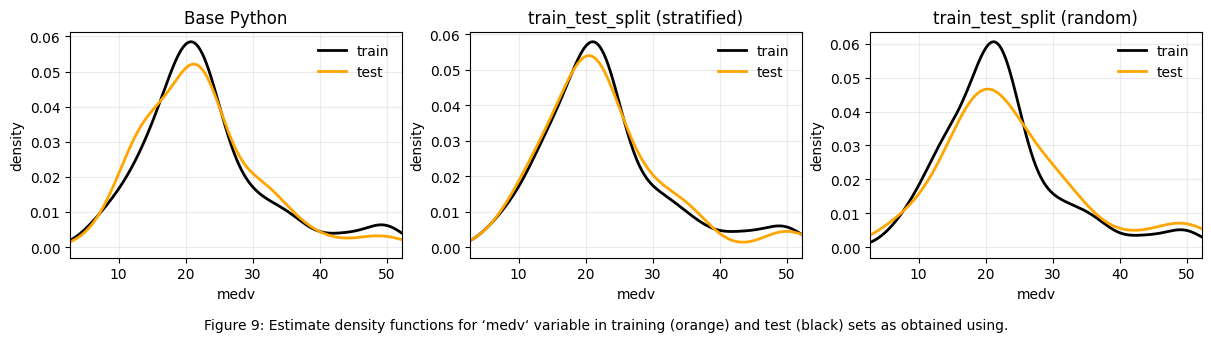

In [132]:
# figure 9: plotting each method demonstrated above:

# Plot helper: overlaid KDEs for train/test 'medv'
def plot_medv_kde(ax, train_df, test_df, title):
    # KDE lines
    train_df["MEDV"].plot(kind="kde", ax=ax, lw=2, color="black", label="train")
    test_df["MEDV"].plot(kind="kde", ax=ax, lw=2, color="orange", label="test")
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("medv")
    ax.set_ylabel("density")
    ax.grid(alpha=0.25)
    ax.legend(frameon=False, loc="upper right")
    # consistent x-limits across panels
    lo = boston_df["MEDV"].min()
    hi = boston_df["MEDV"].max()
    pad = 0.05 * (hi - lo)
    ax.set_xlim(lo - pad, hi + pad)

# ------------------------------------------------------------
# Make the 3-panel figure
fig, axes = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True)

plot_medv_kde(axes[0], train,  test,  "Base Python")
plot_medv_kde(axes[1], train_2, test_2, "train_test_split (stratified)")
plot_medv_kde(axes[2], train_3,  test_3,  "train_test_split (random)")

# Caption
fig.text(0.5, -0.08, "Figure 9: Estimate density functions for ‘medv‘ variable in training (orange) and test (black) sets as obtained using.", ha="center")

plt.show()

Ideally, the distribution of $Y$ in the test set will be similar to that in training set.

Figure 9: Estimate probability density functions for 'MEDV' variable in training (orange) and test (black) sets as obtained using base Python `random.sample()` and `train_test_split()` packages.

**Behavioral Trends:** In Figure 9, we notice the following:

*   **Basic Python**: Manually shuffling and slicing indices; no built-in reproducibility or stratification
*   **`train_test_split()`(stratified)**: Target ($y$) is binned into categories initially, then stratified - meaning the train and test sets have proportional representation of each bin
*   **`train_test_split()` (random)**: same random splitting as *Basic Python*, but its reproducible and cleaner

**Note:** Both *Basic Python* and *`train_test_split()` (random)* KDE impact may yield different train/test target distributions by chance (e.g., especially with small data or skewed target/ data). However, stratification (i.e., with binning for regression) KDE plots of are much closer to each other and to the overall dataset's distribution because models aren't biased by an imbalanced target split.

In [ ]:
X = Boston[["LSTAT"]]; y = Boston["MEDV"]

# train/ test sets (80/20 holdout) (similar to using rsample::initial_split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = 100, shuffle=True
    )

# Grid search over K = 1..100
kgrid = list(range(1, 101))
mse = np.empty(len(kgrid), dtype=float)

for i, k in enumerate(kgrid):
  knn = KNeighborsRegressor(n_neighbors=k)
  knn.fit(X_train, y_train)
  pred = knn.predict(X_test)
  mse[i] = mean_squared_error(y_test, pred)

# Optimal K (min test MSE)
k_opt = kgrid[int(np.argmin(mse))]
mse_opt = mse.min()

print(f"Optimal K: {k_opt}")
print(f"Minimum Test MSE at K={k_opt}: {mse_opt:.4f}")

We demonstrate how to obtain the optimal K, that is, the value of K that gives the best general performance above.

For the full data set, we can tune K using holdout method, and fit the resulting model to the whole data. In particular,

(a) Split the data into training and test sets

(b) For each candidate value of K, fit the model in the training set, and compute MSE using the test set.

(c) Choose the K which gives minimum test MSE.

(d) Fit KNN with optimal K to the full data set.

Then the trained model can be used for future predictions.

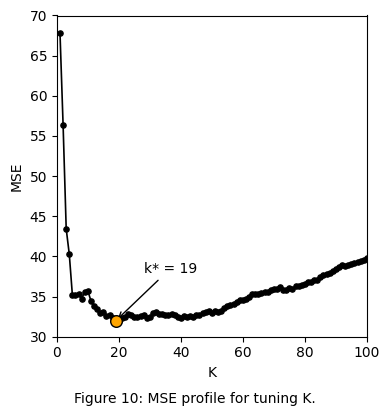

In [45]:
# plot for figure 10:

X = boston_df[["LSTAT"]].values
y = boston_df[["MEDV"]].values.astype(float)

# train/ test sets (80/20 holdout) (similar to using rsample::initial_split)
rng = 100
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = rng, shuffle=True
    )

# Grid search over K = 1..100
kgrid = list(range(1, 101))
mse = np.empty(len(kgrid), dtype=float)

for i, k in enumerate(kgrid):
  knn = KNeighborsRegressor(n_neighbors=k)
  knn.fit(X_train, y_train)
  pred = knn.predict(X_test)
  mse[i] = mean_squared_error(y_test, pred)

# Optimal K (min test MSE)
k_opt = kgrid[int(np.argmin(mse))]
mse_opt = mse.min()

# Plots
fig, ax = plt.subplots(figsize=(4, 4))                 # defines plot framework
ax.plot(kgrid, mse, "-", color="black", lw=1.2, zorder=1)  # connecting line
ax.scatter(kgrid, mse, s=14, c="black")                    # points only
ax.set_xlabel("K")        # labels name to x-axis
ax.set_ylabel("MSE")      # labels name to y-axis
ax.set_xlim(0, 100)       # controls boundaries to x-axis
ax.set_ylim(30, 70)       # controls boundaries to y-axis
ax.grid(False)            # Removes grid lines

# optional: Highlights the optimal K value on the plot
k_opt = int(kgrid[np.argmin(mse)])
ax.annotate(f"k* = {k_opt}",                    # label name of min K value
            xy=(k_opt, mse.min()),              # identifies datapoint of min K value
            xytext=(k_opt+9, mse.min()+6),      # controls text positioning
            arrowprops=dict(arrowstyle="->", lw=1)) # constructs an arrow
ax.scatter([k_opt], [mse_opt], s=70, c="orange", edgecolor="black", zorder=3)  # highlights min K value

# Caption
fig.subplots_adjust(bottom=0.18)                # changes the figure margins
fig.text(0.5, -0.02, "Figure 10: MSE profile for tuning K.", ha="center")

plt.tight_layout()        # automatically adjusts subplot margins and spacing so no overlap or cut offs occur
plt.show()                # displays plot

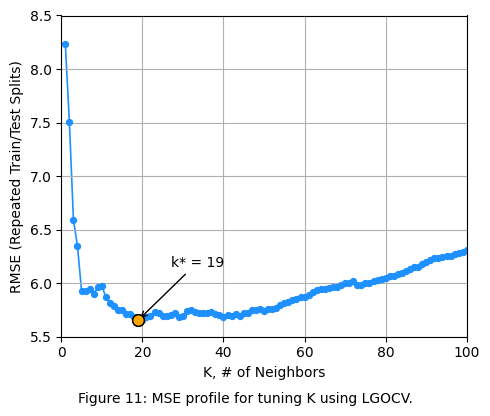

Best K: 19, RMSE: 5.6556


In [134]:
# plot for figure 11

# Parameters governing training process:
  # CV Method: single 80/20 split (LGOCV)
rng = 100
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=rng)

# Candidate values of K (Grid over K = 1..100, score with RMSE)
param_grid = {"n_neighbors": np.arange(1, 101)}
knn = KNeighborsRegressor()

# Training the model
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # RMSE (negated by sklearn)
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
grid.fit(X, y)

# Extract K and RSME values
k_vals = grid.cv_results_["param_n_neighbors"].data.astype(int)
rmse_val = -grid.cv_results_["mean_test_score"]
rmse_trn = -grid.cv_results_.get("mean_train_score", np.full_like(rmse_val, np.nan))
# Extracts optimal values
k_opt = int(grid.best_params_["n_neighbors"])
rmse_opt = rmse_val[k_vals.tolist().index(k_opt)]

# Plots
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(k_vals, rmse_val, "-", color="#1E90FF", lw=1.2, zorder=1)
ax.scatter(k_vals, rmse_val, s=18, c="#1E90FF", zorder=2)
ax.scatter([k_opt], [rmse_opt], s=70, c="orange", edgecolor="black", zorder=3)
ax.set_xlabel("K, # of Neighbors")
ax.set_ylabel("RMSE (Repeated Train/Test Splits)")
ax.set_xlim(0, 100)
ax.set_ylim(5.5, 8.5)
ax.grid(True)

# optional: Highlights the optimal K value on the plot
ax.annotate(f"k* = {k_opt}",
            xy=(k_opt, rmse_opt.min()),
            xytext=(k_opt+8, rmse_opt.min()+0.5),
            arrowprops=dict(arrowstyle="->", lw=1))
ax.scatter([k_opt], [rmse_opt], s=70, c="orange", edgecolor="black", zorder=3)

# Caption
fig.subplots_adjust(bottom=0.18)
fig.text(0.5, -0.02, "Figure 11: MSE profile for tuning K using LGOCV.", ha="center")

plt.tight_layout()
plt.show()

# Prints optimal K and Minmum RMSE values
print(f"Best K: {k_opt}, RMSE: {rmse_opt:.4f}")

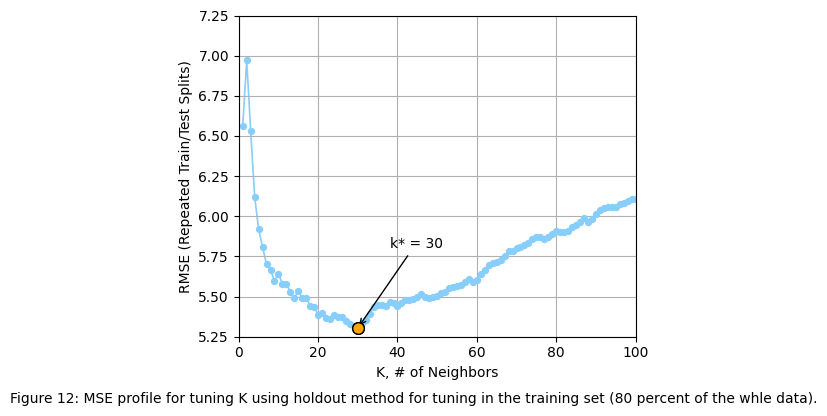

In [47]:
# plot for figure 12

# Parameters governing training process:
  # CV Method: single 80/20 split (LGOCV)
rng = 100
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=rng)

# Candidate values of K (Grid over K = 1..100, score with RMSE)
param_grid = {"n_neighbors": np.arange(1, 101)}
knn = KNeighborsRegressor()

# Training the model on training set
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # RMSE (negated by sklearn)
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
grid.fit(X_train, y_train)

# Optimal K, and refit on the training set
# Extract K and RSME values
k_vals = grid.cv_results_["param_n_neighbors"].data.astype(int)
rmse_val = -grid.cv_results_["mean_test_score"]
rmse_trn = -grid.cv_results_.get("mean_train_score", np.full_like(rmse_val, np.nan))
# Extracts optimal K value
k_opt = int(grid.best_params_["n_neighbors"])
rmse_opt = rmse_val[k_vals.tolist().index(k_opt)]

# Plots
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(k_vals, rmse_val, "-", color="#87CEFA", lw=1.2, zorder=1)
ax.scatter(k_vals, rmse_val, s=18, c="#87CEFA", zorder=2)
ax.scatter([k_opt], [rmse_opt], s=70, c="orange", edgecolor="black", zorder=3)
ax.set_xlabel("K, # of Neighbors")
ax.set_ylabel("RMSE (Repeated Train/Test Splits)")
ax.set_xlim(0, 100)
ax.set_ylim(5.25, 7.25)
ax.grid(True)

# optional: Highlights the optimal K value on the plot
ax.annotate(f"k* = {k_opt}",
            xy=(k_opt, rmse_opt.min()),
            xytext=(k_opt+8, rmse_opt.min()+0.5),
            arrowprops=dict(arrowstyle="->", lw=1))
ax.scatter([k_opt], [rmse_opt], s=70, c="orange", edgecolor="black", zorder=3)

# Caption
fig.subplots_adjust(bottom=0.18)
fig.text(0.5, -0.02, "Figure 12: MSE profile for tuning K using holdout method for tuning in the training set (80 percent of the whle data).", ha="center")

plt.tight_layout()
plt.show()

In [ ]:
# Refit with optimal K (no CV)
knn_final = KNeighborsRegressor(n_neighbors=k_opt)
knn_final.fit(X_train, y_train)

# Predict test set and compute MSE
pred_test = knn_final.predict(X_test)
mse_test = mean_squared_error(y_test, pred_test)
print(f"Test MSE: {mse_test:.5f}")

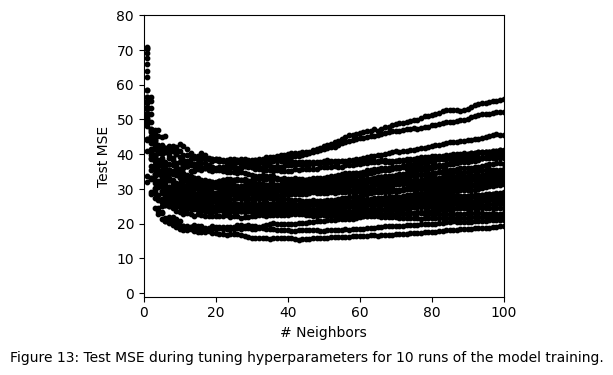

In [50]:
# plot for figure 13

X = boston_df[["LSTAT"]]
y = boston_df[["MEDV"]]

# Settings
kgrid = np.arange(1, 101)       # K = 1..100
n_repeats = 30                  # number of random 80/20 splits (adjust 20–50)
rng = 100
cv = ShuffleSplit(n_splits=n_repeats, test_size=0.2, random_state=rng)

# Compute Test MSE for each split and K
all_mse = []  # each entry: array of shape (len(kgrid),)
for tr_idx, te_idx in cv.split(X):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

    mse_k = np.empty_like(kgrid, dtype=float)
    for i, k in enumerate(kgrid):
        knn = KNeighborsRegressor(n_neighbors=int(k))
        knn.fit(X_tr, y_tr)
        pred = knn.predict(X_te)
        mse_k[i] = mean_squared_error(y_te, pred)
    all_mse.append(mse_k)

# Plot (points only, black)
fig, ax = plt.subplots(figsize=(4.5, 3.6))
for mse_k in all_mse:
    ax.scatter(kgrid, mse_k, s=10, c="black", alpha=1.0)

ax.set_xlabel("# Neighbors")
ax.set_ylabel("Test MSE")
ax.set_xlim(0, 100)
ax.set_ylim(-1, 80)
ax.grid(False)

# Caption
fig.subplots_adjust(bottom=0.18)
fig.text(0.5, -0.02, "Figure 13: Test MSE during tuning hyperparameters for 10 runs of the model training.", ha="center")

plt.tight_layout()
plt.show()

The advantage of the holdout method is that it is conceptually and computationally simple. However, this method can produce highly variable test error.

To see this, we can repeat the hyperparameter tuning procedure a few times. The plot of the test MSE profiles during tuning process is shown in Figure 13 for 10 training runs. As we see, there is a substantial amount of variability in the test MSE.

## **V-fold Cross-validation**

Relates to pages 17-22.

### **Concept**

The V-fold CV procedure splits the data into multiple parts, and then cycles through those parts to compute test MSE. In particular, V-fold CV is performed to estimate the test error of a model/procedure as follows:

1. Split the data randomly into $V$ (roughly) equal sized disjoint parts, called *folds*. Thus we have fold $1, \dots$, fold $V$.

2. For each fold $l= 1,...,V$, do:
  - Set Fold as the test set, and the remaining folds together as the training set.

  - Train the model using the training set and compute MSE using the test set (Fold $l$), say $MSE_l$.

3. The final estimate of test error is formed by taking the average of the V MSE values: $\frac{1}{V} \sum^V_{l=1} MSE_l$.

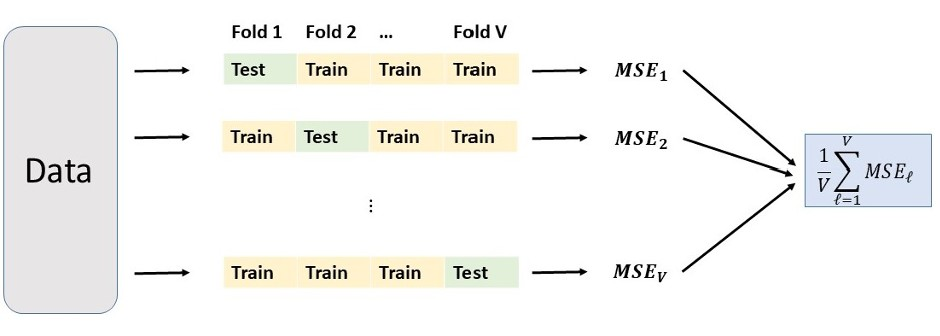

Figure 14: Layout of the V-fold crossvalidation procedure. Data are first randomly split into V equal sized parts, called folds. Each fold is then used as a test set while the remaining folds are used to fit the model. The test error is estimated by taking the average of the MSEs from the V folds.

We can tune hyperparameters using V-fold CV as well:

1. Split the data randomly into V folds.

2. For each fold = 1,...,V, do:
  - Set Fold as the test set, and the remaining folds together as the training set.
  
  - Fit the model using the training set, and evaluate MSE/RMSE22 using the test set (Fold ), for each value of the hyperparameter.

3. From step 2., for each value of hyperparameter, we should have a MSE/RMSE value for each fold (V of them). The final MSE/RMSE for each of the hyperparameter value is calculated by taking the mean of V MSE/RMSE values from the V folds. Chose the optimal value of the hyperparameter by minimizing the final MSE/RMSE.

4. Use the best hyperparameter value to refit the model on the whole dataset.

If we want to estimate the test MSE/RMSE of the tuned model, we can follow the same strategy as in with holdout method. We can use either holdout or V-fold CV in the outer loop.

An advantage of V-fold CV is that every observation in the data will be used once as a part of test set, and V 1 times as a part of training set. Another advantage of V-fold CV is that it provides test MSEs which have much less variability than those from holdout method.

### **Application**

In [51]:
# Verison 1
# V-fold Cross-Validation (V = 5), done manually (no helpers)
V = 5
n = boston_df.shape[0]
fold_sizes = (n // V) * np.ones(V, dtype=int)
fold_sizes[: n % V] += 1  # spread the remainder
starts = np.cumsum(np.r_[0, fold_sizes[:-1]])
stops  = np.cumsum(fold_sizes)

X = boston_df[["LSTAT"]]
y = boston_df[["MEDV"]]

mse_folds = []
for v in range(V):
    val_idx = np.arange(starts[v], stops[v])
    train_idx = np.setdiff1d(np.arange(n), val_idx)

    X_train, y_train = X.values[train_idx], y.values[train_idx]
    X_val,   y_val   = X.values[val_idx],   y.values[val_idx]

    _vfold = knn.fit(X_train, y_train)
    y_val_pred = knn.predict(X_val)

    mse_v = np.mean((y_val - y_val_pred) ** 2)
    mse_folds.append(mse_v)

#print("Fold MSEs:", mse_folds)
print("V-fold CV MSE (mean):", round(np.mean(mse_folds),4))

V-fold CV MSE (mean): 38.4127


In [135]:
# Version 2

X = boston_df[["LSTAT"]]
y = boston_df[["MEDV"]]

# estimator
k = 30; knn = KNeighborsRegressor(n_neighbors=k)

# 5-fold cross-validation (like trainControl(method="cv", number=5))
rng = 100
cv5 = KFold(n_splits=5, shuffle=True, random_state=rng)

# scoring dict (hint: flip signs for neg_* later)
scoring = {
    "rmse": "neg_root_mean_squared_error",   # if your sklearn lacks this, see note below
    "r2": "r2",
    "mae": "neg_mean_absolute_error",
    "mse": "neg_mean_squared_error"
}

# run CV
res = cross_validate(knn, X, y, cv=cv5, scoring=scoring, n_jobs=-1, return_train_score=False)

# get per-fold train/test sizes from the same CV splitter (deterministic given random_state)
sizes = [(len(train), len(test)) for train, test in cv5.split(X, y)]

# assemble per-fold table
per_fold = pd.DataFrame({
    "fold": np.arange(1, cv5.get_n_splits() + 1),
    "train_n": [s[0] for s in sizes],
    "test_n":  [s[1] for s in sizes],
    "RMSE": -res["test_rmse"],              # negate because sklearn uses neg_* convention
    "R2":   res["test_r2"],
    "MAE": -res["test_mae"],
    "MSE": -res["test_mse"]
}).round(4)

# summary (mean ± sd)
summary = per_fold[["RMSE", "R2", "MAE", "MSE"]].agg(["mean", "std"]).round(4)
print(per_fold.to_string(index=False))
print("\nSummary:\n", summary)


 fold  train_n  test_n   RMSE     R2    MAE     MSE
    1      404     102 5.6875 0.6651 4.2452 32.3479
    2      405     101 5.4696 0.6535 3.6634 29.9167
    3      405     101 5.0306 0.6851 3.7463 25.3070
    4      405     101 4.5722 0.7028 3.1326 20.9047
    5      405     101 5.2022 0.6884 4.0393 27.0632

Summary:
         RMSE      R2     MAE      MSE
mean  5.1924  0.6790  3.7654  27.1079
std   0.4280  0.0196  0.4232   4.3895


### **Figures**

2 plots

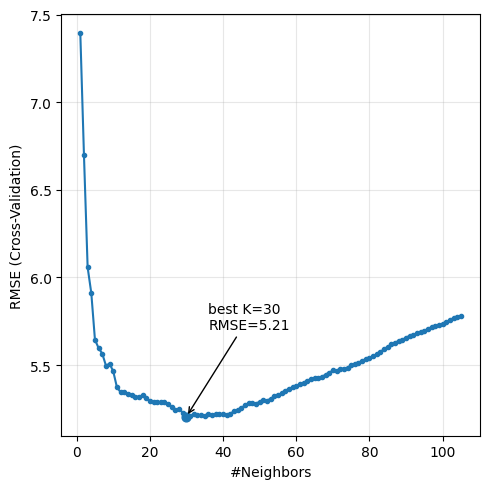

In [54]:
X = boston_df[["LSTAT"]]; y = boston_df[["MEDV"]]

rng= 100
cv5 = KFold(n_splits=5, shuffle=True, random_state=rng)
k_values = np.arange(1, 106)  # 1..105 neighbors

rmse = []
for k in k_values:
    model = KNeighborsRegressor(n_neighbors=k)
    # neg MSE -> take mean over folds -> sqrt to get RMSE
    cv_mse = -cross_val_score(model, X, y,
                              scoring="neg_mean_squared_error",
                              cv=cv5, n_jobs=-1)
    rmse.append(np.sqrt(cv_mse.mean()))
rmse = np.array(rmse)

k_best = k_values[rmse.argmin()]
rmse_best = rmse.min()

# Plot (matplotlib; single axes; no explicit colors)
plt.figure(figsize=(5, 5))
plt.plot(k_values, rmse, marker='o', markersize=3, linewidth=1.5)
plt.grid(True, alpha=0.3)
plt.xlabel("#Neighbors")
plt.ylabel("RMSE (Cross-Validation)")
# Optional: highlight the best point
plt.scatter([k_best], [rmse_best], s=40)
plt.annotate(f"best K={k_best}\nRMSE={rmse_best:.2f}",
             xy=(k_best, rmse_best),
             xytext=(k_best+6, rmse_best+0.5),
             arrowprops=dict(arrowstyle="->", lw=1))
plt.tight_layout()
plt.show()

Figure 15: Results from hyperparameter tuning using 5-fold CV.

In [136]:
def tuned_knn_cv(X, y, train_idx, test_idx, k_grid=range(1, 101), inner_folds=5, seed=rng):
    """
    Mirrors the R function:
      - tune K on train fold via inner CV
      - refit with best K on full train fold
      - return test MSE on the held-out fold
    """
    # row-based indexing
    X_tr = X.iloc[train_idx].to_numpy()
    y_tr = y.iloc[train_idx].to_numpy().ravel()
    X_te = X.iloc[test_idx].to_numpy()
    y_te = y.iloc[test_idx].to_numpy().ravel()

    # inner CV for tuning
    inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=seed)
    gs = GridSearchCV(
        estimator=KNeighborsRegressor(),
        param_grid={'n_neighbors': list(k_grid)},
        scoring='neg_mean_squared_error',
        cv=inner_cv,
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_tr, y_tr)

    k_opt = gs.best_params_['n_neighbors']

    # refit on full training fold with optimal K (trainControl(method="none"))
    knn_tuned = KNeighborsRegressor(n_neighbors=k_opt).fit(X_tr, y_tr)

    # predict test fold and compute MSE
    preds = knn_tuned.predict(X_te)
    test_mse = mean_squared_error(y_te, preds)

    return test_mse  # (return k_opt too if you want)

# ---- apply to each outer split (v-fold CV) and average ----
X = boston_df[["LSTAT"]]; y = boston_df[["MEDV"]]
v = 5  # set your outer v-fold here to match folds$splits
rng=100
outer_cv = KFold(n_splits=v, shuffle=True, random_state=rng)

mse_folds = []
for tr_idx, te_idx in outer_cv.split(X, y):
    mse_folds.append(tuned_knn_cv(X, y, tr_idx, te_idx, k_grid=range(1, 101), inner_folds=5, seed=rng))

MSE_test = float(np.mean(mse_folds))
print("Outer-CV Test MSE (mean over folds):", round(MSE_test, 4))
#print("Per-fold MSEs:", [round(m, 4) for m in mse_folds])

Outer-CV Test MSE (mean over folds): 27.5916


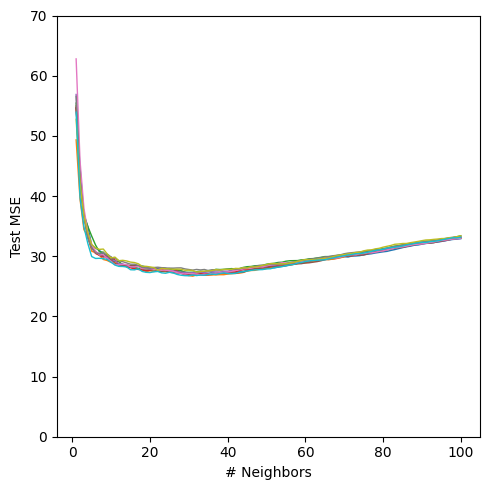

In [56]:
X = boston_df[["LSTAT"]]; y = boston_df[["MEDV"]]

rng = 100
repeats = 10
k_values = np.arange(1, 101)   # 1..100 neighbors
mse_curves = np.zeros((repeats, len(k_values)))

for r in range(repeats):
    cv5 = KFold(n_splits=5, shuffle=True, random_state=rng + r)  # new shuffle each repeat
    for i, k in enumerate(k_values):
        model = KNeighborsRegressor(n_neighbors=k)
        # mean test MSE over the 5 folds for this repeat
        fold_mse = -cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=cv5, n_jobs=-1)
        mse_curves[r, i] = fold_mse.mean()

# ---- Plot to match the style of your figure ----
plt.figure(figsize=(5, 5))
for r in range(repeats):
    plt.plot(k_values, mse_curves[r], linewidth=1)  # default black lines

plt.xlabel("# Neighbors")
plt.ylabel("Test MSE")
plt.ylim(0, 70)                 # matches the axis range in your screenshot
plt.tight_layout()
plt.show()

Figure 16: Results from hyperparameter tuning using 5-fold CV, repeated 10 times.

## **Leave-One-Out Cross-Validation (LOOCV)**
Relates to pages 22-24.

### **Concept**

As a special case of $V$-fold cross-validation, consider the case with $V = n$, where $n$ is the sample size of your data. In this case, every observation will be its own fold. Suppose we observe data $(Y_i,X_i)$ for $i = 1,\dots,n$.

The CV then proceeds as follows:

1. For observation (fold) $i = 1,\dots,n$, do
  * Set the $i$-th observation $(Y_i,X_i)$ as the test set, and the remaining $n-1$ asthe training set.
  * Fit the model on the training set, and predict $Y_i$ (test set)
  * Compute $MSE_i = (Y_i \hat{Y_i})^2$

2. Compute the test MSE as the average of the $n$ MSE values from step 1., that is, $ \frac{1}{n} \sum_{i=1}^n MSE_i$.

**Advantages:**

There are two advantages of LOOCV over the holdout method:

* First, the holdout method fits the models on a smaller subset of the full data (e.g., 80% of whole data, even less if another loop/tuning is involved). This may introduce bias in estimation of test error– the holdout method often overestimates the test error due to the fact that the model is trained using a smaller sample. In contrast, LOOCV trains the model using $n-1$ observations, which is effectively the entire dataset, and thus reducing estimation bias.

* There is no random splitting of the data since LOOCV cycles through every observation systematically. Thus results from running LOOCV multiple times will give the same answer, whereas running the holdout method multiple times on the same dataset may give (very) different results.

**Disadvantages:**

Its potential heavy computation cost, especially for large sample size.

For example, in Boston data (n = 506), we have to fit $n-1 = 505$ models for each value of $K$! This can be extremely difficult for larger $n$.

In contrast, holdout and $V$-fold CV procedures are more computationally efficient.

**bias-variance trade-off:**

As a final note on cross-validation, the choice of $V$ in V-fold cross-validation depends the bias-variance trade-off of the procedure. Given a sample size of n, the V-fold CV uses approximately $(V-1)n/V$ observation to fit the model. Thus LOOCV effectively uses the whole data to rain the model, and therefore produces almost unbiased estimates of the test error. However, a 5-gold CV might produce a biased estimate.

On the other hand, in LOOCV the $n$ model fits essentially uses the same dataset (any two fits share $n-2$ common training observations), the resulting test MSE values are highly correlated. Averaging the $n$ in MSE values LOOCV does not reduce the variance due to them being highly correlated. Thus LOOCV estimates tend to have high variance.

In contrast, a 5-fold CV does not have as high level of overlap between the training folds, and produces less variable estimates of test MSE.

In practice, we most often use 5-fold or 10-fold cross validation.

### **Application**

In [137]:
# Version 1
# Leave-One-Out Cross-Validation (LOOCV), done “by hand”
X = boston_df[["LSTAT"]].values
y = boston_df[["MEDV"]].values.astype(float)

n = boston_df.shape[0]
sse = 0.0  # sum of squared errors
for i in range(n):
    # train on all except i, test on i
    train_idx = np.delete(np.arange(n), i)
    X_train, y_train = X[train_idx], y[train_idx]
    X_test_i, y_test_i = X[i:i+1], y[i:i+1]

    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_i_pred = knn.predict(X_test_i)[0]

    sse += (y_test_i[0] - y_i_pred) ** 2

mse_loocv = sse / n
print("LOOCV MSE:", mse_loocv)

LOOCV MSE: [27.7820783]


In [138]:
# Version 2

X = boston_df[["LSTAT"]].values
y = boston_df[["MEDV"]].values.astype(float)

k=30; knn = KNeighborsRegressor(n_neighbors=k)

# LOOCV
loo = LeaveOneOut()
mse_loocv = -cross_val_score(
    knn, X, y, scoring="neg_mean_squared_error", cv=loo, n_jobs=-1
    ).mean()
print("LOOCV MSE (K=30):", round(mse_loocv, 7))


LOOCV MSE (K=30): 27.7820783


### **Figures**
2 plots

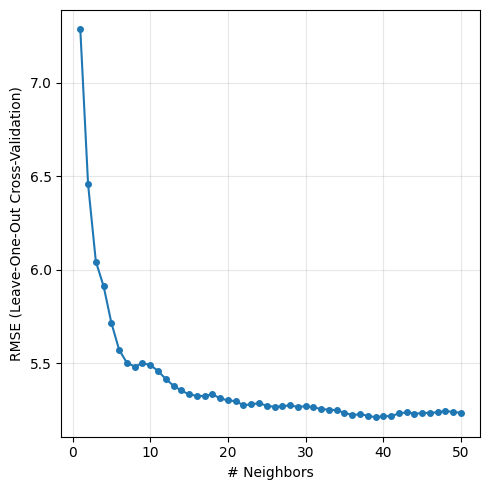

In [141]:
X = boston_df[["LSTAT"]]; y = boston_df[["MEDV"]]

def knn_model(k):
    return KNeighborsRegressor(n_neighbors=k)

# LOOCV sweep over K
loo = LeaveOneOut()
k_values = np.arange(1, 51)     # 1..50
rmse = []

for k in k_values:
    # mean MSE over LOOCV folds, then sqrt -> RMSE
    mse_mean = -cross_val_score(
        knn_model(k), X, y, scoring="neg_mean_squared_error", cv=loo, n_jobs=-1
    ).mean()
    rmse.append(np.sqrt(mse_mean))

rmse = np.array(rmse)
k_best = k_values[rmse.argmin()]

# --- Plot (style to resemble your figure) ---
plt.figure(figsize=(5, 5))
plt.plot(k_values, rmse, marker='o', linewidth=1.5, markersize=4)
plt.xlabel("# Neighbors")
plt.ylabel("RMSE (Leave-One-Out Cross-Validation)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Figure 17: Results from tuning K using LOOCV on the whole Boston data.

In [147]:
print(f"Best K: {k_best}")
print(f"RMSE = {rmse.min():.4f}")
print(f"MSE = {mse_mean.min():.4f}")

Best K: 39
RMSE = 5.3497
MSE = 27.4239


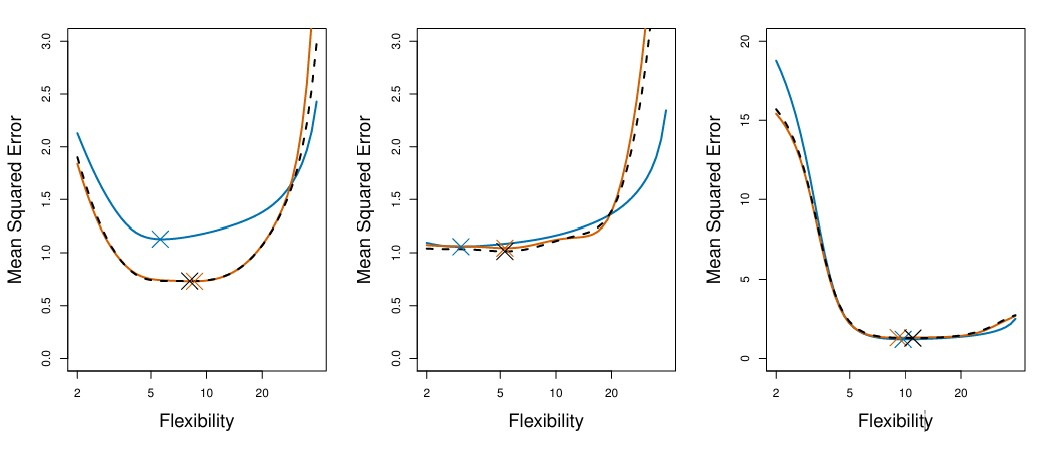

Figure 18: Comparison of CV estimate of test error and its minimizer compared to true test error in several simulation studies. Shown are the true test MSE (blue), LOOCV estimate (black dashed line), and the 10-fold CV estimate (orange), along with their minimum (cross). Figure and caption adapted from Introduction to Statistical Learning, Figure 5.6.

Figure 18 shows true test MSE, and the estimates using 10-fold CV and LOOCV for a few simulation scenarios. We can observe that estimates from 10-fold CV and LOOCV are very similar. However, the quality (bias) of the estimates changes depending on the scenario. On the other hand, even though sometimes the CV estimate underestimate the true test error, the minimizer of the CV estimates are very close to the minimizer of the true test error. Thus they tend to correctly identify the flexibility (e.g., how small/large K should be in KNN) of the procedure.

## **Bootstrapping**
Relates to pages 24-28.

### **Concept**

A *bootstrap sample* is a random sample with replacement that is of the same size as the original data. Since the sampling is performed with replacement, some observations (i.e., rows) will be repeated in the bootstrap sample, and therefore a few observations in the original data will not be included in the bootstrap sample. The omitted observations are called *out-of-bag (OOB)* samples.


____________________________________________

* **Bootstrap sample:** A random sample drawn with replacement of the original data.
* **Out-Of-Bag sample:** The observations not included in the bootstrap sample.


**Bootstrap Procedure**


Given a dataset $D$, suppose we want to compute some quantity $S(D)$ based on the whole dataset. We can use bootstrap to assess any aspect of the distribution of $S(D)$ (e.g., mean, variance, quantiles etc.) as follows:

* Draw $B$ bootstrap samples from the original data, call them $D^*_1,...,D^*_B$.
* For $b=1, \dots, B$, do
  - Use the $b$-th bootstrap sample, $D^*_b$ to compute the same quantity you computed based on the original data, $S(D^*_b)$. For example, if we want to compute sample mean of the original data, we would need to compute sample mean using the bootstrap sample as well.
* Use the bootstrap estimates $S(D^*_1),...,S(D*_B)$ to assess properties of $S(D)$.

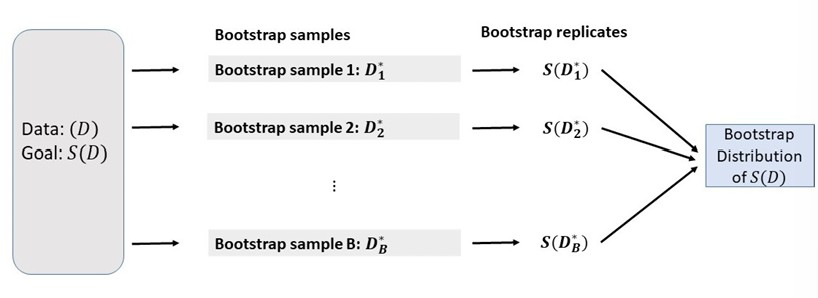

We can examine the distribution of $S(D)$ by estimating it by using the bootstrap replicates $S(D^*_1),...,S(D_B)$ (e.g., a histogram or a density estimate).

We can estimate the variance of $S(D)$ using the sample variance of the replicates:

$$ \hat{var} \{S(D)\} = \frac{1}{B-1} \sum^B_{b=1} [S(D^*_b)-\bar{S^*}]^2,$$

where $S^* = \sum^B_{b=1} S(D^*_b)/B$ is the sample mean of the bootstrap replicates.

### **Application**

In [78]:
# Version 1

X = boston_df[["LSTAT"]].values
y = boston_df[["MEDV"]].values.astype(float)
n = boston_df.shape[0]

seed = 100
rng = np.random.RandomState(seed)

# Bootstrap (out-of-bag error), B resamples
B = 200
oob_mses = []

for b in range(B):
    boot_idx = rng.randint(0, n, size=n)                  # sample with replacement
    oob_mask = np.ones(n, dtype=bool)
    oob_mask[boot_idx] = False
    oob_idx = np.where(oob_mask)[0]

    if len(oob_idx) == 0:   # sometimes (rarely) all points get sampled
        continue

    X_boot, y_boot = X[boot_idx], y[boot_idx]
    X_oob,  y_oob  = X[oob_idx],  y[oob_idx]

    _bool = knn.fit(X_boot, y_boot)
    y_oob_pred = knn.predict(X_oob)

    oob_mse = np.mean((y_oob - y_oob_pred) ** 2)
    oob_mses.append(oob_mse)

print("Mean OOB MSE over", len(oob_mses), "bootstrap samples:", round(np.mean(oob_mses),4))

Mean OOB MSE over 200 bootstrap samples: 28.727


In [85]:
# Version 2

rng=100
bag = BaggingRegressor(
    estimator=KNeighborsRegressor(n_neighbors=k),  # or wrap in a Pipeline that scales
    n_estimators=200,
    bootstrap=True,
    oob_score=True,
    random_state=rng
)

bag.fit(X, y)
oob_pred = bag.oob_prediction_
print("Bootstrap (Bagging OOB) MSE:", round(mean_squared_error(y, oob_pred),5))


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_bagging.py:568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


Bootstrap (Bagging OOB) MSE: 27.67999


### **Figures**

4 plots

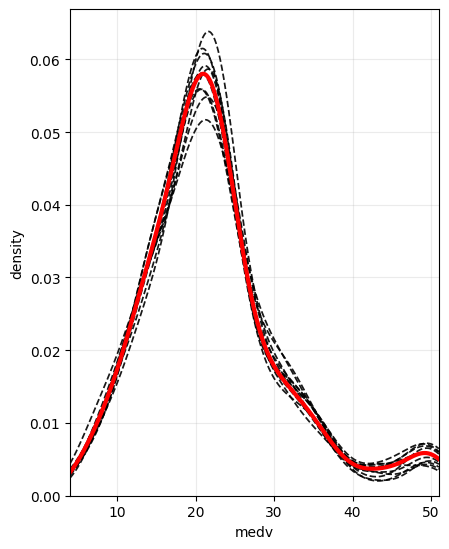

In [125]:
# Figure 19 — KDE of medv (red) + 10 bootstrap KDEs (black dashed)

y = boston_df["MEDV"]#.values.astype(float)

# Grid for evaluating densities
xs = np.linspace(y.min() - 1, y.max() + 1, 600)

# KDE for full data (use Silverman to resemble R's density())
kde_full = gaussian_kde(y, bw_method='silverman')
ys_full = kde_full(xs)

# 10 bootstrap KDE curves
rng = np.random.default_rng(100)
n_boot = 10
boot_curves = []
n = y.size
for _ in range(n_boot):
    boot = rng.choice(y, size=n, replace=True)      # 1D bootstrap sample
    kde_b = gaussian_kde(boot, bw_method='silverman')
    boot_curves.append(kde_b(xs))

# ---- plot ----
plt.figure(figsize=(4.6, 5.6))
for ys in boot_curves:
    plt.plot(xs, ys, 'k--', linewidth=1.25, alpha=0.9)   # dashed black; bootstrap curves
plt.plot(xs, ys_full, color='red', linewidth=3)          # solid red

plt.xlabel("medv")
plt.ylabel("density")
plt.xlim(xs.min(), xs.max())
plt.ylim(bottom=0)
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


Figure 19: Distribution of ‘medv‘ in the Boston data (red solid line), and in 10 bootstrap samples (black dashed lines).

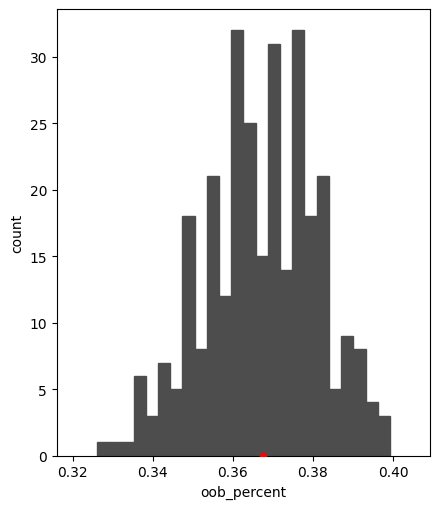

In [92]:
# --- settings ---
rng = np.random.default_rng(100)
n = boston_df.shape[0]    # sample size of the original dataset
B = 300                   # number of bootstrap resamples
bins = 24                 # histogram bins

# --- simulate OOB % across bootstrap samples ---
oob_percent = []
for _ in range(B):
    draw = rng.integers(0, n, size=n)            # bootstrap sample (with replacement)
    unique_selected = np.unique(draw).size
    oob = 1.0 - unique_selected / n              # fraction of original obs NOT sampled
    oob_percent.append(oob)

oob_percent = np.asarray(oob_percent)
theory = (1 - 1/n)**n         # ≈ 1 - 1/e

# --- plot ---
plt.figure(figsize=(4.5, 5.2))
plt.hist(oob_percent, bins=bins, color='0.3', edgecolor='0.3')
plt.xlabel("oob_percent")
plt.ylabel("count")

# red dot at theoretical mean on the x-axis
plt.scatter([theory], [0], s=20, color='red', zorder=3)

# nice x-limits similar to the figure
xmin = max(0.31, oob_percent.min() - 0.01)
xmax = min(0.41, oob_percent.max() + 0.01)
plt.xlim(xmin, xmax)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()
#Figure 20: Percent of original observations in OOB sample.

Figure 20: Percent of original observations in OOB sample.

In [93]:
print(f"Empirical mean OOB%: {oob_percent.mean():.4f}")
print(f"Theoretical OOB% (~1 - 1/e): {theory:.4f}")

Empirical mean OOB%: 0.3671
Theoretical OOB% (~1 - 1/e): 0.3675


/tmp/ipython-input-3882533472.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_k30 = float(knn.predict(x0))
/tmp/ipython-input-3882533472.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  boot_preds[b] = float(knn_b.predict(x0))
/tmp/ipython-input-3882533472.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  boot_preds[b] = float(knn_b.predict(x0))
/tmp/ipython-input-3882533472.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scala

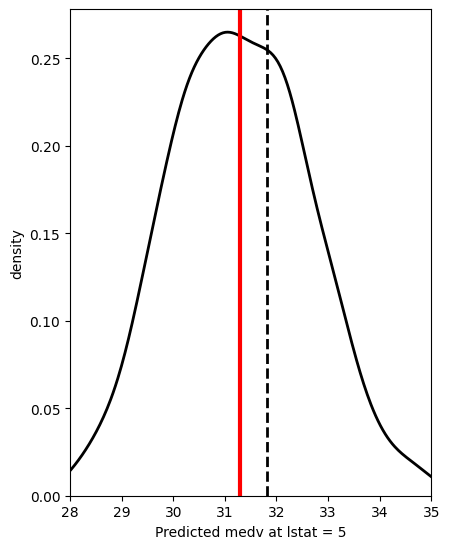

In [112]:
# Figure 22 — Bootstrap distribution of E[medv | lstat = 5]

X = boston_df[["LSTAT"]].values
y = boston_df[["MEDV"]].values.astype(float)

x0 = np.array([[5.0]])            # predict at lstat = 5
k = 30

# Full-data estimate
knn = KNeighborsRegressor(n_neighbors=k).fit(X, y)
pred_k30 = float(knn.predict(x0))

# Bootstrap sampling distribution
B = 1000
rng = np.random.default_rng(100)
n = boston_df.shape[0]

boot_preds = np.empty(B)
for b in range(B):
    idx = rng.integers(0, n, size=n)     # bootstrap indices
    knn_b = KNeighborsRegressor(n_neighbors=k).fit(X[idx], y[idx])
    boot_preds[b] = float(knn_b.predict(x0))

# KDE of bootstrap estimates
xs = np.linspace(boot_preds.min() - 0.5, boot_preds.max() + 0.5, 400)
kde = gaussian_kde(boot_preds, bw_method='silverman')
ys = kde(xs)

# Plot
plt.figure(figsize=(3.6, 4.6))
plt.plot(xs, ys, color='black', linewidth=2)
plt.axvline(boot_preds.mean(), color='red', linewidth=3)          # bootstrap mean
plt.axvline(pred_k30, color='black', linestyle='--', linewidth=2)  # full-data estimate
plt.xlabel("Predicted medv at lstat = 5")
plt.ylabel("density")
plt.xlim(28, 35)       # to match the look of your figure
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

Figure 22: Distribution of estimator of E(medv when lstst = 5). Also shown the mean of the bootstrap estimates (red solid line), and original estimate from the full data (black dashed line).

In [121]:
print(f"Bootstrap mean (red solid line): {boot_preds.mean():.6f}")
print(f"Original estimate at lstat=5 (black dashed line): {pred_k30:.6f}")

Bootstrap mean (red solid line): 31.300537
Original estimate at lstat=5 (black dashed line): 31.810000


In [110]:
## Summary of bootstrap estimates
pd.DataFrame(boot_preds).describe()

,0
count,1000.000000
mean,31.300537
std,1.341416
min,27.900000
25%,30.319167
50%,31.258333
75%,32.228333
max,36.130000


In [119]:
## Variance/ SD/ MSE of the estimate
print(f"variance: {boot_preds.var():.6f}")
print(f"sdev: {boot_preds.std(ddof=1):.6f}")
print("MSE:", round(np.mean((boot_preds - pred_k30)**2),6))

variance: 1.797597
sdev: 1.341416
MSE: 2.05715


Best K: 41


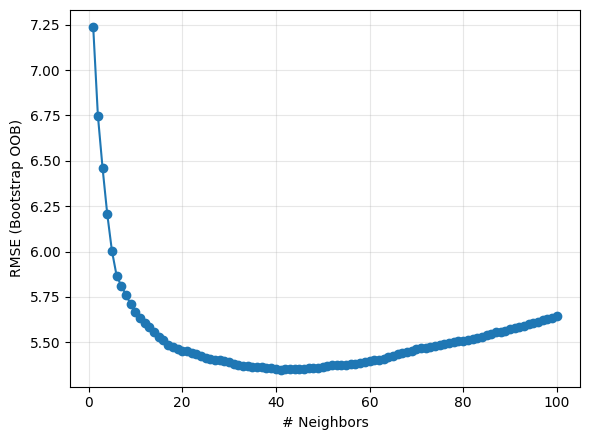

In [148]:
X = boston_df[["LSTAT"]].values
y = boston_df[["MEDV"]].values.astype(float)
n = boston_df.shape[0]
rng=100

# bootstrap-OOB CV iterator (like trainControl(method="boot", number=25))
def bootstrap_oob_cv(n_samples, n_boot=25, random_state=None):
    rng = check_random_state(random_state)
    splits = []
    while len(splits) < n_boot:
        train_idx = rng.randint(0, n_samples, size=n_samples)  # with replacement
        oob_mask = np.ones(n_samples, dtype=bool)
        oob_mask[np.unique(train_idx)] = False
        test_idx = np.flatnonzero(oob_mask)                    # OOB indices
        if test_idx.size == 0:   # extremely rare; resample to keep exactly n_boot splits
            continue
        splits.append((train_idx, test_idx))
    return splits

cv_boot = bootstrap_oob_cv(n_samples=n, n_boot=25, random_state=rng)

# grid over K and fit
k_values = np.arange(1, 101)  # 1..100
grid = {'n_neighbors': k_values}
gs = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=grid,
    scoring='neg_mean_squared_error',  # MSE on OOB each bootstrap
    cv=cv_boot,
    n_jobs=-1,
    refit=True
)
gs.fit(X, y)

print("Best K:", gs.best_params_['n_neighbors'])

# plot RMSE vs K (like plot(boot_tuned_knn))
mean_mse = -gs.cv_results_['mean_test_score']
rmse = np.sqrt(mean_mse)

plt.figure(figsize=(6, 4.5))
plt.plot(k_values, rmse, marker='o', linewidth=1.5)
plt.xlabel("# Neighbors")
plt.ylabel("RMSE (Bootstrap OOB)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Figure 23: Results from bootstrap (25 reps) tuning of K.

Intepretations:

* Figure
* Figure

## **Method Comparsion**

What's distinctly different among each method?

*   **Holdout:** one train/test split; simplest and fastest.
*   **V-fold CV:** data split into V folds; each fold is validation once; average the V MSEs.
*   **LOOCV:** special case of V-fold with V = n; each time holding out a single point, train n times on the rest, and repeat for all points.
    *  *Additionally*: **LOGO-CV (aka LOGOCV):** hold out on a group (i.e., clump of single points) of observations each time. Initially, you must supply a groups array indicating which rows belong together.
*   **Bootstrap (OOB):** resample with replacement B times; evaluate on the “out-of-bag” points each time; average OOB MSEs.